# Modelling using SVM

In [14]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Using device: cuda


In [15]:
import pandas as pd

df = pd.read_csv('../data/preprocessed/review_tiktok_dataset_sentiment_indobertweet.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   at                100000 non-null  object 
 1   reviewId          100000 non-null  object 
 2   userName          100000 non-null  object 
 3   score             100000 non-null  int64  
 4   content           100000 non-null  object 
 5   cleaning          100000 non-null  object 
 6   case_folding      100000 non-null  object 
 7   no_elongation     100000 non-null  object 
 8   formalization     99773 non-null   object 
 9   tokenized         100000 non-null  object 
 10  stopword_removal  100000 non-null  object 
 11  stemming          100000 non-null  object 
 12  sentiment         100000 non-null  object 
 13  confident_score   100000 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 10.7+ MB


In [16]:
df_filtered = df[df['confident_score'] >= 0.9]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78304 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   at                78304 non-null  object 
 1   reviewId          78304 non-null  object 
 2   userName          78304 non-null  object 
 3   score             78304 non-null  int64  
 4   content           78304 non-null  object 
 5   cleaning          78304 non-null  object 
 6   case_folding      78304 non-null  object 
 7   no_elongation     78304 non-null  object 
 8   formalization     78295 non-null  object 
 9   tokenized         78304 non-null  object 
 10  stopword_removal  78304 non-null  object 
 11  stemming          78304 non-null  object 
 12  sentiment         78304 non-null  object 
 13  confident_score   78304 non-null  float64
dtypes: float64(1), int64(1), object(12)
memory usage: 9.0+ MB


In [17]:
df_filtered.isna().sum()

at                  0
reviewId            0
userName            0
score               0
content             0
cleaning            0
case_folding        0
no_elongation       0
formalization       9
tokenized           0
stopword_removal    0
stemming            0
sentiment           0
confident_score     0
dtype: int64

In [18]:
df_filtered = df_filtered.dropna(subset=['formalization']).reset_index(drop=True)

In [19]:
df_filtered.isna().sum()

at                  0
reviewId            0
userName            0
score               0
content             0
cleaning            0
case_folding        0
no_elongation       0
formalization       0
tokenized           0
stopword_removal    0
stemming            0
sentiment           0
confident_score     0
dtype: int64

## Sentiment Distribution

In [20]:
df_filtered['sentiment'].value_counts()

sentiment
Negative    58747
Positive    10881
Neutral      8667
Name: count, dtype: int64

## Data Split

In [21]:
from sklearn.model_selection import train_test_split

X = df_filtered['stemming']
y = df_filtered['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})


## Resampling

In [22]:
train_df['label'].value_counts()

label
Negative    46998
Positive     8705
Neutral      6933
Name: count, dtype: int64

In [23]:
from sklearn.utils import resample

# Pisahkan tiap kelas
df_negative = train_df[train_df['label'] == 'Negative'].sample(n=20000, random_state=42)

df_positive = resample(
    train_df[train_df['label'] == 'Positive'],
    replace=True,
    n_samples=20000,  
    random_state=42
)

df_neutral = resample(
    train_df[train_df['label'] == 'Neutral'],
    replace=True,
    n_samples=20000,
    random_state=42
)

# Gabungkan dan acak
train_balanced = pd.concat([df_negative, df_positive, df_neutral]).sample(frac=1, random_state=42).reset_index(drop=True)


In [24]:
train_balanced['label'].value_counts()

label
Negative    20000
Positive    20000
Neutral     20000
Name: count, dtype: int64

## TF-IDF Vectorization & Modelling

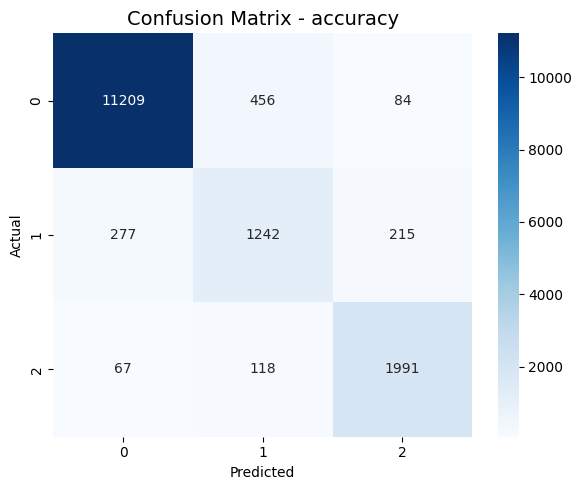

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.95      0.96     11749
     Neutral       0.68      0.72      0.70      1734
    Positive       0.87      0.91      0.89      2176

    accuracy                           0.92     15659
   macro avg       0.84      0.86      0.85     15659
weighted avg       0.92      0.92      0.92     15659



In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=80000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(train_balanced['text'])
X_test_vec = vectorizer.transform(test_df['text'])

# Train Model
model = SVC(kernel='linear', random_state=42)
model.fit(X_train_vec, train_balanced['label'])

# Predict
y_true = test_df['label']
y_pred = model.predict(X_test_vec)

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - accuracy', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=2, zero_division=0))

In [26]:
import joblib

# Simpan model SVM
joblib.dump(model, '../models/svm_model.pkl')

# Simpan TF-IDF vectorizer
joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')


['../models/tfidf_vectorizer.pkl']